### This needs to be run first to install Detectron2. After installation, restart the runtime and skip this cell. Also this code should be run on a GPU session.

In [ ]:
# !pip install pyyaml==5.1

# import torch
# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# # Install detectron2 that matches the above pytorch version
# # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# # If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# # exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

### Adding access to dataset, and import necessary packages.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/CV_final/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CV_final


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Define data reading function and register this with the dataset in Detectron2.

In [ ]:
from detectron2.structures import BoxMode
def get_box_dicts(img_dir):
    json_file = os.path.join(img_dir, "data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}        
        filename = os.path.join(img_dir, v['img_name'])
        height, width = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).shape[:2]        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for room in v["points"]:
            # if(room[4]!=1 and room[4]!=3):
            #   continue
            xmin = room[0]
            xmax = room[2]
            ymin = room[1]
            ymax = room[3]
            room_digit = 1
            if(room[4]==3 or room[4]==1):
              room_digit = room[4]-1


            px = [xmin,xmin,xmax,xmax]
            py = [ymin,ymax,ymax,ymin]
            poly = [(x - 0.5, y - 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": room_digit,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("data_512_" + d, lambda d=d: get_box_dicts("data_512_" + d))
    # MetadataCatalog.get("data_512_" + d).set(thing_classes=['bathroom','bedroom','living room','stairs','others'])
    MetadataCatalog.get("data_512_" + d).set(thing_classes=['bedroom','others','stairs'])
room_metadata = MetadataCatalog.get("data_512_train")

### visualize image with labels to confirm that the dataset reading function is properly defined.

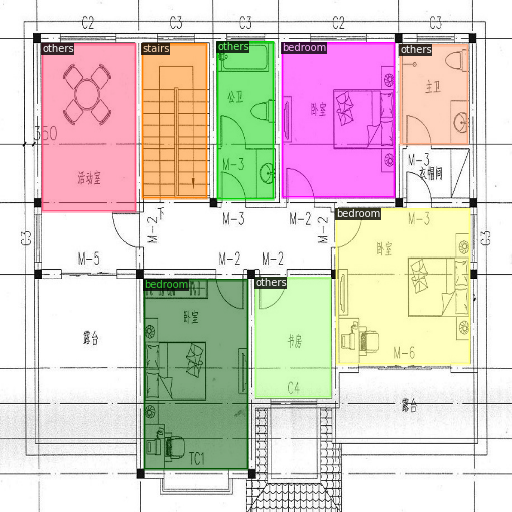

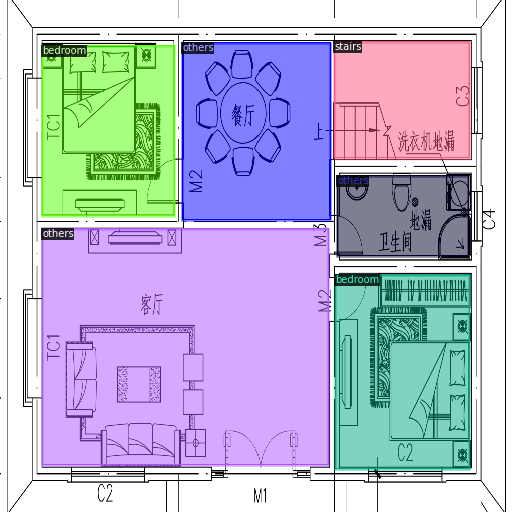

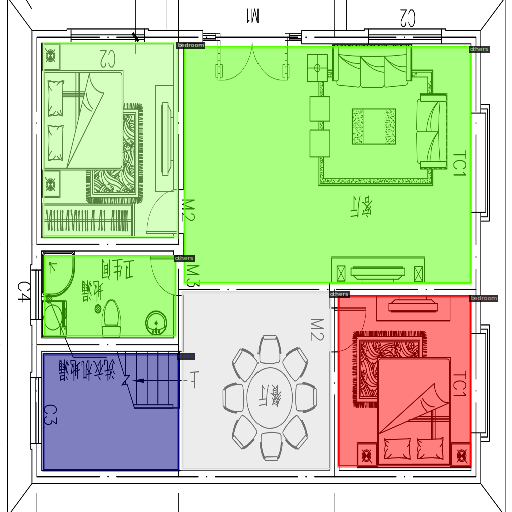

In [ ]:

# dataset_dicts = get_box_dicts("data_512_val")
# # dataset_dicts = get_box_dicts("data_512_train")

# for d in random.sample(dataset_dicts, 3):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=room_metadata, scale=1)
#     out = visualizer.draw_dataset_dict(d)
#     cv2_imshow(out.get_image()[:, :, ::-1])

### Training with different backbone models.

In [ ]:
from detectron2.engine import DefaultTrainer

pretrained_model = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
# pretrained_model = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
# pretrained_model = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(pretrained_model))
cfg.DATASETS.TRAIN = ("data_512_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(pretrained_model)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 800    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

### Evaluate model performance with testset.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


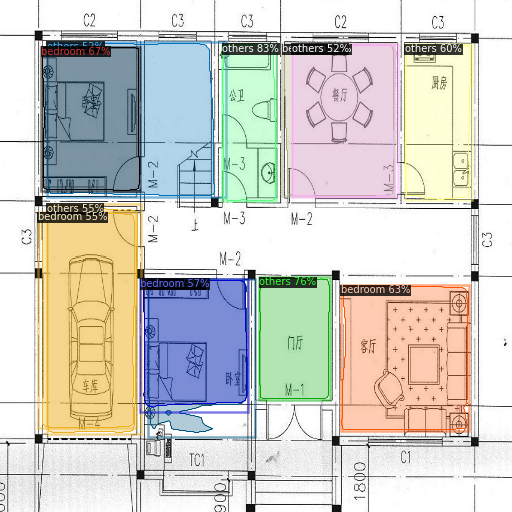

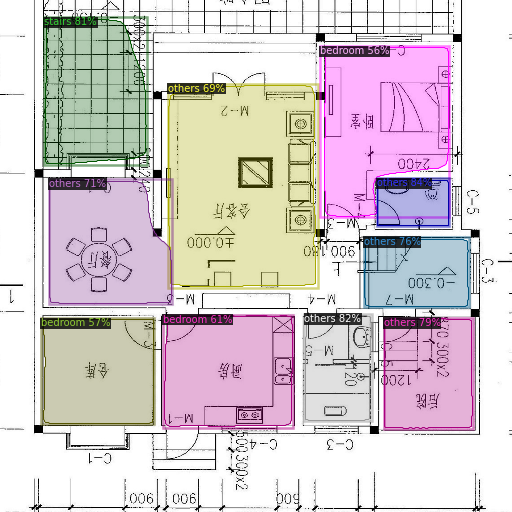

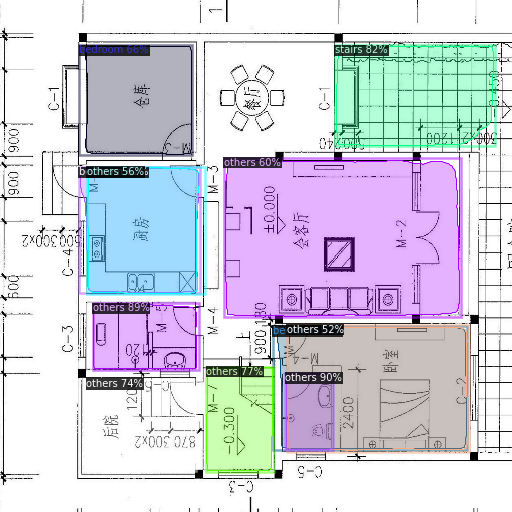

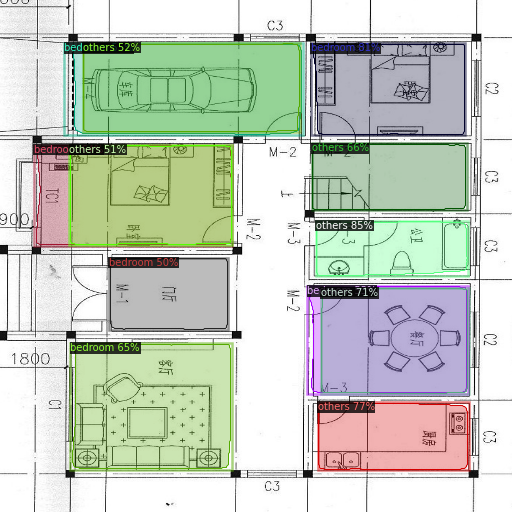

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_box_dicts("data_512_val")
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=room_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("data_512_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "data_512_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/14 23:20:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/14 23:20:28 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[12/14 23:20:28 d2.data.common]: Serialized dataset takes 0.04 MiB
[12/14 23:20:28 d2.evaluation.evaluator]: Start inference on 40 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/14 23:20:32 d2.evaluation.evaluator]: Inference done 11/40. Dataloading: 0.0015 s/iter. Inference: 0.3912 s/iter. Eval: 0.0092 s/iter. Total: 0.4020 s/iter. ETA=0:00:11
[12/14 23:20:38 d2.evaluation.evaluator]: Inference done 24/40. Dataloading: 0.0017 s/iter. Inference: 0.3979 s/iter. Eval: 0.0114 s/iter. Total: 0.4112 s/iter. ETA=0:00:06
[12/14 23:20:43 d2.evaluation.evaluator]: Inference done 37/40. Dataloading: 0.0017 s/iter. Inference: 0.3948 s/iter. Eval: 0.0109 s/iter. Total: 0.4077 s/iter. ETA=0:00:01
[12/14 23:20:44 d2.evaluation.evaluator]: Total inference time: 0:00:14.312052 (0.408916 s / iter per device, on 1 devices)
[12/14 23:20:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:13 (0.394580 s / iter per device, on 1 devices)
[12/14 23:20:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/14 23:20:44 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[12/14 23:20:44 d2.evaluation.coco_eva